# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [85]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [87]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [88]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [89]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [90]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [91]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [92]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [93]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [94]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [95]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [96]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [97]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [98]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [99]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [100]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [101]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [102]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [103]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [104]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [105]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [106]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [107]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████| 4986/4986 [00:01<00:00, 2906.13it/s]


In [108]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [162]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization, Dense, Dropout, Flatten

In [163]:
data = {'Text':preprocessed_reviews,'score':final['Score'] }
df = pd.DataFrame(data)
print(df)


                                                   Text  score
2546  product available victor traps unreal course t...      1
2547  used victor fly bait seasons ca not beat great...      1
1145  received shipment could hardly wait try produc...      1
1146  really good idea final product outstanding use...      1
2942  glad cocker standard poodle puppy loves stuff ...      1
2941  using food months find excellent fact two dogs...      1
1071  nine cats crazy kibbles last thing want cat fo...      1
2187  shipped day ordered arrived within days live o...      1
4695  mix probably not something would want use ever...      1
2068  description product disceptive product represe...      0
2069  bought brand online indian grocery store usual...      0
2806  use keep finicky toddler protein levels great ...      1
2805  get busy home like sausage lot quick meal opti...      1
4099  company american classic business years best h...      1
4096  love pico pica adds flavor not hot eat least m...

In [164]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Text'].values,
                                                            df['score'],
                                                            test_size=0.3,
                                                            shuffle=False,
                                                            random_state=0)
print("shape of the Train",x_train.shape[0],"and the shape of the test",x_test.shape[0])

shape of the Train 3490 and the shape of the test 1496


In [165]:
x_tr = pd.DataFrame(x_train)
print(x_tr[0])

0       product available victor traps unreal course t...
1       used victor fly bait seasons ca not beat great...
2       received shipment could hardly wait try produc...
3       really good idea final product outstanding use...
4       glad cocker standard poodle puppy loves stuff ...
5       using food months find excellent fact two dogs...
6       nine cats crazy kibbles last thing want cat fo...
7       shipped day ordered arrived within days live o...
8       mix probably not something would want use ever...
9       description product disceptive product represe...
10      bought brand online indian grocery store usual...
11      use keep finicky toddler protein levels great ...
12      get busy home like sausage lot quick meal opti...
13      company american classic business years best h...
14      love pico pica adds flavor not hot eat least m...
15      thank goodness mexgrocer love pico pica sauce ...
16      different sauce nothing like anything find gro...
17      found 

In [166]:
x_te = pd.DataFrame(x_test)
print(x_te[0])

0       ordered bags free shipping reviews really like...
1       doctor told must eat hulless popcorn popcorn n...
2       popcorn yummy warned trouble popping using air...
3       pops great microwave much better many store br...
4       love little white kernels popped corn good stu...
5       great popcorn good popping results wonderful f...
6       sweetest smallest hulless best tasting white p...
7       not claim professional food taster know like n...
8       really good tender little sweet easy make whir...
9       little concerned buy popcorn never know going ...
10      love popcorn shipping costs insane total rip w...
11          small white popcorn best delicious tried lots
12      like much harder find white popcorn common yel...
13      love popcorn downside shipping packing cost al...
14      best popcorn ever kid ran popcorn machine thea...
15      years bought lot popcorn popping found small b...
16      first popcorn year old cousin home thought ten...
17      best p

In [167]:
words = []
for sen in x_tr[0]:
    word = sen.split()
    words += word
print(words[10])
print("\n No of words",len(words))

stinky

 No of words 132484


In [168]:
 def Unique(data):
        uq_words = []
        for x in data:
            if x not in uq_words:
                uq_words.append(x)
        return uq_words

In [169]:
words_unique = Unique(words)

In [170]:
print("Number of unique words",len(words_unique)+1)

Number of unique words 11233


In [171]:
from collections import Counter
counts = Counter(words)
print(len(counts))
count = counts.most_common(2000)
print(count[:20])

11232
[('not', 3417), ('like', 1368), ('good', 1207), ('great', 1100), ('chips', 984), ('one', 909), ('product', 883), ('would', 866), ('taste', 859), ('food', 855), ('flavor', 808), ('love', 767), ('tea', 763), ('no', 673), ('coffee', 647), ('really', 577), ('get', 571), ('much', 558), ('amazon', 548), ('bag', 522)]


In [172]:
word_index = dict()
i = 1
for word,frequency in count:
    word_index[word] = i
    i += 1

In [173]:
from itertools import islice
print("Top 25 words with their index:")
print(list(islice(word_index.items(), 25)))

Top 25 words with their index:
[('not', 1), ('like', 2), ('good', 3), ('great', 4), ('chips', 5), ('one', 6), ('product', 7), ('would', 8), ('taste', 9), ('food', 10), ('flavor', 11), ('love', 12), ('tea', 13), ('no', 14), ('coffee', 15), ('really', 16), ('get', 17), ('much', 18), ('amazon', 19), ('bag', 20), ('time', 21), ('also', 22), ('buy', 23), ('use', 24), ('find', 25)]


In [174]:
def apply_text_index(row):  
    holder = []
    for word in row.split():
        if word in word_index:
            holder.append(word_index[word]) 
        else:
            holder.append(0)            
    return holder


x_tr = x_tr[0].apply(lambda row: apply_text_index(row))
x_tr

0       [7, 240, 0, 0, 0, 403, 992, 0, 0, 147, 1985, 8...
1                    [40, 0, 0, 0, 0, 1116, 1, 614, 4, 7]
2       [228, 800, 37, 1434, 868, 36, 7, 12, 0, 845, 2...
3       [16, 3, 466, 0, 7, 1364, 24, 0, 1253, 0, 0, 0,...
4       [304, 1435, 751, 1851, 752, 94, 124, 1306, 50,...
5       [115, 10, 202, 25, 105, 267, 60, 86, 0, 1035, ...
6       [0, 309, 894, 0, 195, 134, 98, 272, 10, 309, 7...
7       [424, 74, 87, 233, 540, 229, 411, 0, 0, 45, 58...
8       [38, 244, 1, 88, 8, 98, 24, 1307, 148, 110, 12...
9       [895, 7, 0, 7, 0, 316, 1, 316, 0, 224, 0, 234,...
10      [44, 50, 382, 0, 174, 52, 184, 105, 91, 241, 9...
11      [24, 126, 1988, 1366, 357, 996, 4, 57, 51, 107...
12      [17, 1989, 182, 2, 1857, 100, 341, 413, 1367, ...
13      [186, 1079, 1440, 1217, 71, 27, 128, 112, 0, 1...
14      [12, 0, 0, 869, 11, 1, 128, 34, 290, 925, 84, ...
15      [335, 1310, 0, 12, 0, 0, 112, 459, 25, 7, 103,...
16      [121, 112, 224, 2, 131, 25, 174, 52, 1741, 0, ...
17      [42, 7

In [175]:
x_te =  x_te[0].apply(lambda row: apply_text_index(row))
x_te

0       [87, 53, 61, 129, 178, 16, 2, 183, 1238, 526, ...
1       [0, 527, 342, 34, 0, 573, 573, 1, 85, 68, 64, ...
2       [573, 414, 0, 919, 0, 115, 706, 0, 0, 197, 8, ...
3              [1425, 4, 1204, 18, 32, 55, 52, 130, 3, 7]
4       [12, 28, 205, 0, 1609, 238, 3, 124, 63, 36, 47...
5       [4, 573, 3, 0, 587, 156, 11, 1116, 1, 538, 12,...
6       [0, 0, 0, 27, 231, 205, 573, 73, 1908, 1589, 5...
7       [1, 1865, 0, 10, 0, 70, 2, 1, 2, 1, 2, 1295, 5...
8       [16, 3, 1722, 28, 48, 82, 35, 0, 378, 105, 560...
9       [28, 1192, 23, 573, 78, 70, 170, 17, 304, 573,...
10      [12, 573, 129, 1186, 0, 992, 0, 0, 0, 647, 19,...
11                       [101, 205, 573, 27, 57, 33, 630]
12      [2, 18, 1309, 25, 205, 573, 1221, 1295, 573, 0...
13      [12, 573, 0, 129, 1789, 369, 167, 18, 573, 122...
14      [27, 573, 73, 1026, 1230, 573, 814, 0, 172, 70...
15      [71, 44, 100, 573, 0, 42, 101, 275, 205, 0, 27...
16      [39, 573, 140, 92, 0, 182, 153, 1722, 57, 312,...
17      [27, 5

In [176]:
print(x_tr[1])
print(type(x_tr[1]))
print(len(x_tr[1]))

[40, 0, 0, 0, 0, 1116, 1, 614, 4, 7]
<class 'list'>
10


In [179]:
max_review_length = 100
x_tr = sequence.pad_sequences(x_tr, maxlen=max_review_length)
x_te = sequence.pad_sequences(x_te, maxlen=max_review_length)

print(x_tr.shape)
print(x_tr[1])

(3490, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   40    0    0    0    0 1116    1  614
    4    7]


### 1) 1-layered LSTM + sigmoid + adagrad

In [195]:
top_words = 2000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 32)           64032     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 117,333
Trainable params: 117,333
Non-trainable params: 0
_________________________________________________________________
None


In [206]:
validation_data=(x_te, y_test)
value = model.fit(x_tr, y_train, nb_epoch=7, batch_size=32,verbose=1,validation_data=(x_te, y_test))
# Final evaluation of the model
scores = model.evaluate(x_te, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3490 samples, validate on 1496 samples
Epoch 1/7
3490/3490 [==============================] - ETA: 2:55 - loss: 0.0141 - acc: 1.000 - ETA: 1:51 - loss: 0.0166 - acc: 1.000 - ETA: 1:32 - loss: 0.0135 - acc: 1.000 - ETA: 1:21 - loss: 0.0113 - acc: 1.000 - ETA: 1:15 - loss: 0.0117 - acc: 1.000 - ETA: 1:09 - loss: 0.0142 - acc: 1.000 - ETA: 1:03 - loss: 0.0141 - acc: 1.000 - ETA: 59s - loss: 0.0148 - acc: 1.000 - ETA: 55s - loss: 0.0144 - acc: 1.00 - ETA: 52s - loss: 0.0131 - acc: 1.00 - ETA: 50s - loss: 0.0127 - acc: 1.00 - ETA: 48s - loss: 0.0133 - acc: 1.00 - ETA: 46s - loss: 0.0144 - acc: 1.00 - ETA: 44s - loss: 0.0141 - acc: 1.00 - ETA: 43s - loss: 0.0134 - acc: 1.00 - ETA: 43s - loss: 0.0135 - acc: 1.00 - ETA: 41s - loss: 0.0131 - acc: 1.00 - ETA: 40s - loss: 0.0126 - acc: 1.00 - ETA: 39s - loss: 0.0134 - acc: 1.00 - ETA: 38s - loss: 0.0130 - acc: 1.00 - ETA: 37s - loss: 0.0137 - acc: 1.00 - ETA: 36s - loss: 0.0139 - acc: 1.00 - ETA: 35s - loss: 0.0139 - acc: 1.00 - ETA: 35s

3490/3490 [==============================] - ETA: 57s - loss: 0.0022 - acc: 1.00 - ETA: 56s - loss: 0.0058 - acc: 1.00 - ETA: 50s - loss: 0.0084 - acc: 1.00 - ETA: 52s - loss: 0.0070 - acc: 1.00 - ETA: 57s - loss: 0.0065 - acc: 1.00 - ETA: 56s - loss: 0.0057 - acc: 1.00 - ETA: 51s - loss: 0.0078 - acc: 1.00 - ETA: 51s - loss: 0.0092 - acc: 1.00 - ETA: 53s - loss: 0.0096 - acc: 1.00 - ETA: 51s - loss: 0.0106 - acc: 1.00 - ETA: 49s - loss: 0.0103 - acc: 1.00 - ETA: 47s - loss: 0.0100 - acc: 1.00 - ETA: 47s - loss: 0.0100 - acc: 1.00 - ETA: 45s - loss: 0.0099 - acc: 1.00 - ETA: 45s - loss: 0.0101 - acc: 1.00 - ETA: 43s - loss: 0.0101 - acc: 1.00 - ETA: 42s - loss: 0.0116 - acc: 0.99 - ETA: 42s - loss: 0.0114 - acc: 0.99 - ETA: 41s - loss: 0.0115 - acc: 0.99 - ETA: 40s - loss: 0.0118 - acc: 0.99 - ETA: 39s - loss: 0.0113 - acc: 0.99 - ETA: 39s - loss: 0.0109 - acc: 0.99 - ETA: 38s - loss: 0.0107 - acc: 0.99 - ETA: 37s - loss: 0.0105 - acc: 0.99 - ETA: 36s - loss: 0.0102 - acc: 0.99 - ETA: 

3490/3490 [==============================] - ETA: 50s - loss: 0.0124 - acc: 1.00 - ETA: 50s - loss: 0.0118 - acc: 1.00 - ETA: 45s - loss: 0.0111 - acc: 1.00 - ETA: 44s - loss: 0.0120 - acc: 1.00 - ETA: 45s - loss: 0.0102 - acc: 1.00 - ETA: 44s - loss: 0.0093 - acc: 1.00 - ETA: 42s - loss: 0.0085 - acc: 1.00 - ETA: 41s - loss: 0.0076 - acc: 1.00 - ETA: 39s - loss: 0.0080 - acc: 1.00 - ETA: 38s - loss: 0.0081 - acc: 1.00 - ETA: 37s - loss: 0.0085 - acc: 1.00 - ETA: 36s - loss: 0.0083 - acc: 1.00 - ETA: 35s - loss: 0.0079 - acc: 1.00 - ETA: 35s - loss: 0.0075 - acc: 1.00 - ETA: 34s - loss: 0.0071 - acc: 1.00 - ETA: 33s - loss: 0.0070 - acc: 1.00 - ETA: 32s - loss: 0.0071 - acc: 1.00 - ETA: 32s - loss: 0.0070 - acc: 1.00 - ETA: 31s - loss: 0.0068 - acc: 1.00 - ETA: 30s - loss: 0.0066 - acc: 1.00 - ETA: 30s - loss: 0.0067 - acc: 1.00 - ETA: 29s - loss: 0.0064 - acc: 1.00 - ETA: 28s - loss: 0.0064 - acc: 1.00 - ETA: 28s - loss: 0.0062 - acc: 1.00 - ETA: 27s - loss: 0.0064 - acc: 1.00 - ETA: 

3490/3490 [==============================] - ETA: 29s - loss: 0.0023 - acc: 1.00 - ETA: 28s - loss: 0.0059 - acc: 1.00 - ETA: 28s - loss: 0.0064 - acc: 1.00 - ETA: 28s - loss: 0.0072 - acc: 1.00 - ETA: 28s - loss: 0.0068 - acc: 1.00 - ETA: 36s - loss: 0.0064 - acc: 1.00 - ETA: 41s - loss: 0.0069 - acc: 1.00 - ETA: 40s - loss: 0.0066 - acc: 1.00 - ETA: 39s - loss: 0.0061 - acc: 1.00 - ETA: 38s - loss: 0.0057 - acc: 1.00 - ETA: 39s - loss: 0.0054 - acc: 1.00 - ETA: 39s - loss: 0.0056 - acc: 1.00 - ETA: 39s - loss: 0.0055 - acc: 1.00 - ETA: 38s - loss: 0.0053 - acc: 1.00 - ETA: 38s - loss: 0.0055 - acc: 1.00 - ETA: 37s - loss: 0.0055 - acc: 1.00 - ETA: 37s - loss: 0.0054 - acc: 1.00 - ETA: 36s - loss: 0.0053 - acc: 1.00 - ETA: 36s - loss: 0.0054 - acc: 1.00 - ETA: 35s - loss: 0.0054 - acc: 1.00 - ETA: 35s - loss: 0.0054 - acc: 1.00 - ETA: 36s - loss: 0.0053 - acc: 1.00 - ETA: 35s - loss: 0.0052 - acc: 1.00 - ETA: 34s - loss: 0.0051 - acc: 1.00 - ETA: 35s - loss: 0.0050 - acc: 1.00 - ETA: 

3490/3490 [==============================] - ETA: 53s - loss: 0.0048 - acc: 1.00 - ETA: 49s - loss: 0.0044 - acc: 1.00 - ETA: 58s - loss: 0.0037 - acc: 1.00 - ETA: 1:01 - loss: 0.0035 - acc: 1.000 - ETA: 1:00 - loss: 0.0035 - acc: 1.000 - ETA: 57s - loss: 0.0034 - acc: 1.000 - ETA: 52s - loss: 0.0036 - acc: 1.00 - ETA: 50s - loss: 0.0038 - acc: 1.00 - ETA: 49s - loss: 0.0038 - acc: 1.00 - ETA: 46s - loss: 0.0038 - acc: 1.00 - ETA: 44s - loss: 0.0036 - acc: 1.00 - ETA: 42s - loss: 0.0034 - acc: 1.00 - ETA: 40s - loss: 0.0033 - acc: 1.00 - ETA: 41s - loss: 0.0034 - acc: 1.00 - ETA: 40s - loss: 0.0035 - acc: 1.00 - ETA: 39s - loss: 0.0034 - acc: 1.00 - ETA: 38s - loss: 0.0033 - acc: 1.00 - ETA: 37s - loss: 0.0033 - acc: 1.00 - ETA: 37s - loss: 0.0033 - acc: 1.00 - ETA: 36s - loss: 0.0033 - acc: 1.00 - ETA: 35s - loss: 0.0032 - acc: 1.00 - ETA: 34s - loss: 0.0032 - acc: 1.00 - ETA: 34s - loss: 0.0032 - acc: 1.00 - ETA: 33s - loss: 0.0032 - acc: 1.00 - ETA: 32s - loss: 0.0031 - acc: 1.00 - 

3490/3490 [==============================] - ETA: 31s - loss: 0.0013 - acc: 1.00 - ETA: 50s - loss: 0.0035 - acc: 1.00 - ETA: 48s - loss: 0.0042 - acc: 1.00 - ETA: 51s - loss: 0.0047 - acc: 1.00 - ETA: 51s - loss: 0.0042 - acc: 1.00 - ETA: 49s - loss: 0.0036 - acc: 1.00 - ETA: 47s - loss: 0.0032 - acc: 1.00 - ETA: 47s - loss: 0.0037 - acc: 1.00 - ETA: 45s - loss: 0.0034 - acc: 1.00 - ETA: 42s - loss: 0.0034 - acc: 1.00 - ETA: 40s - loss: 0.0032 - acc: 1.00 - ETA: 39s - loss: 0.0033 - acc: 1.00 - ETA: 37s - loss: 0.0032 - acc: 1.00 - ETA: 36s - loss: 0.0035 - acc: 1.00 - ETA: 35s - loss: 0.0034 - acc: 1.00 - ETA: 34s - loss: 0.0032 - acc: 1.00 - ETA: 33s - loss: 0.0032 - acc: 1.00 - ETA: 32s - loss: 0.0031 - acc: 1.00 - ETA: 31s - loss: 0.0033 - acc: 1.00 - ETA: 31s - loss: 0.0032 - acc: 1.00 - ETA: 30s - loss: 0.0031 - acc: 1.00 - ETA: 29s - loss: 0.0030 - acc: 1.00 - ETA: 29s - loss: 0.0030 - acc: 1.00 - ETA: 29s - loss: 0.0030 - acc: 1.00 - ETA: 29s - loss: 0.0030 - acc: 1.00 - ETA: 

3490/3490 [==============================] - ETA: 28s - loss: 0.0020 - acc: 1.00 - ETA: 28s - loss: 0.0042 - acc: 1.00 - ETA: 28s - loss: 0.0035 - acc: 1.00 - ETA: 34s - loss: 0.0036 - acc: 1.00 - ETA: 33s - loss: 0.0030 - acc: 1.00 - ETA: 32s - loss: 0.0028 - acc: 1.00 - ETA: 33s - loss: 0.0027 - acc: 1.00 - ETA: 32s - loss: 0.0028 - acc: 1.00 - ETA: 31s - loss: 0.0027 - acc: 1.00 - ETA: 32s - loss: 0.0030 - acc: 1.00 - ETA: 32s - loss: 0.0028 - acc: 1.00 - ETA: 35s - loss: 0.0026 - acc: 1.00 - ETA: 34s - loss: 0.0026 - acc: 1.00 - ETA: 35s - loss: 0.0027 - acc: 1.00 - ETA: 35s - loss: 0.0025 - acc: 1.00 - ETA: 34s - loss: 0.0025 - acc: 1.00 - ETA: 33s - loss: 0.0024 - acc: 1.00 - ETA: 33s - loss: 0.0023 - acc: 1.00 - ETA: 32s - loss: 0.0023 - acc: 1.00 - ETA: 31s - loss: 0.0024 - acc: 1.00 - ETA: 31s - loss: 0.0024 - acc: 1.00 - ETA: 31s - loss: 0.0023 - acc: 1.00 - ETA: 31s - loss: 0.0023 - acc: 1.00 - ETA: 30s - loss: 0.0023 - acc: 1.00 - ETA: 29s - loss: 0.0025 - acc: 1.00 - ETA: 

In [207]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.90%


In [208]:
def plot_train_cv_loss(trained_model, epochs, colors=['b']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'b', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

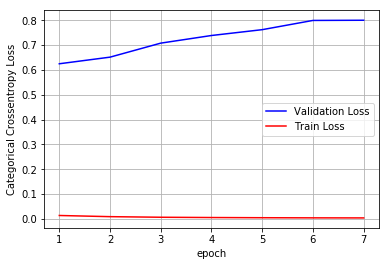

In [210]:
plot_train_cv_loss(value, epochs = 7, colors=['b'])

### 2) 1-layered LSTM + sigmoid + adam + BN + Dropouts

In [218]:
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(200))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 32)           64032     
_________________________________________________________________
lstm_12 (LSTM)               (None, 200)               186400    
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 201       
Total params: 251,433
Trainable params: 251,033
Non-trainable params: 400
_________________________________________________________________
None


In [220]:
validation_data=(x_te, y_test)
value = model.fit(x_tr, y_train, nb_epoch=10, batch_size=64,verbose=1,validation_data=(x_te, y_test))
# Final evaluation of the model
scores = model.evaluate(x_te, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3490 samples, validate on 1496 samples
Epoch 1/10
3490/3490 [==============================] - ETA: 3:00 - loss: 0.6948 - acc: 0.484 - ETA: 1:35 - loss: 0.6865 - acc: 0.539 - ETA: 1:07 - loss: 0.6843 - acc: 0.567 - ETA: 53s - loss: 0.6846 - acc: 0.570 - ETA: 44s - loss: 0.6831 - acc: 0.57 - ETA: 38s - loss: 0.6792 - acc: 0.59 - ETA: 34s - loss: 0.6783 - acc: 0.58 - ETA: 31s - loss: 0.6741 - acc: 0.59 - ETA: 28s - loss: 0.6708 - acc: 0.60 - ETA: 26s - loss: 0.6701 - acc: 0.60 - ETA: 24s - loss: 0.6672 - acc: 0.61 - ETA: 23s - loss: 0.6637 - acc: 0.61 - ETA: 22s - loss: 0.6597 - acc: 0.62 - ETA: 20s - loss: 0.6564 - acc: 0.63 - ETA: 19s - loss: 0.6530 - acc: 0.64 - ETA: 19s - loss: 0.6500 - acc: 0.64 - ETA: 18s - loss: 0.6441 - acc: 0.65 - ETA: 18s - loss: 0.6418 - acc: 0.65 - ETA: 17s - loss: 0.6389 - acc: 0.66 - ETA: 17s - loss: 0.6348 - acc: 0.66 - ETA: 16s - loss: 0.6325 - acc: 0.67 - ETA: 16s - loss: 0.6300 - acc: 0.67 - ETA: 15s - loss: 0.6264 - acc: 0.67 - ETA: 14s - loss

3490/3490 [==============================] - ETA: 15s - loss: 0.0859 - acc: 0.96 - ETA: 17s - loss: 0.0751 - acc: 0.97 - ETA: 18s - loss: 0.0730 - acc: 0.97 - ETA: 19s - loss: 0.0711 - acc: 0.98 - ETA: 20s - loss: 0.0683 - acc: 0.98 - ETA: 20s - loss: 0.0691 - acc: 0.98 - ETA: 20s - loss: 0.0653 - acc: 0.98 - ETA: 19s - loss: 0.0642 - acc: 0.99 - ETA: 19s - loss: 0.0650 - acc: 0.98 - ETA: 18s - loss: 0.0678 - acc: 0.98 - ETA: 17s - loss: 0.0685 - acc: 0.98 - ETA: 17s - loss: 0.0686 - acc: 0.98 - ETA: 17s - loss: 0.0718 - acc: 0.98 - ETA: 17s - loss: 0.0718 - acc: 0.98 - ETA: 17s - loss: 0.0727 - acc: 0.98 - ETA: 17s - loss: 0.0715 - acc: 0.98 - ETA: 17s - loss: 0.0714 - acc: 0.98 - ETA: 16s - loss: 0.0709 - acc: 0.98 - ETA: 15s - loss: 0.0686 - acc: 0.98 - ETA: 15s - loss: 0.0686 - acc: 0.98 - ETA: 14s - loss: 0.0695 - acc: 0.98 - ETA: 14s - loss: 0.0708 - acc: 0.98 - ETA: 13s - loss: 0.0696 - acc: 0.98 - ETA: 13s - loss: 0.0703 - acc: 0.98 - ETA: 12s - loss: 0.0689 - acc: 0.98 - ETA: 

3490/3490 [==============================] - ETA: 31s - loss: 0.0212 - acc: 1.00 - ETA: 30s - loss: 0.0160 - acc: 1.00 - ETA: 28s - loss: 0.0142 - acc: 1.00 - ETA: 29s - loss: 0.0164 - acc: 1.00 - ETA: 27s - loss: 0.0156 - acc: 1.00 - ETA: 24s - loss: 0.0155 - acc: 1.00 - ETA: 23s - loss: 0.0142 - acc: 1.00 - ETA: 23s - loss: 0.0211 - acc: 0.99 - ETA: 21s - loss: 0.0206 - acc: 0.99 - ETA: 20s - loss: 0.0202 - acc: 0.99 - ETA: 20s - loss: 0.0199 - acc: 0.99 - ETA: 20s - loss: 0.0194 - acc: 0.99 - ETA: 19s - loss: 0.0209 - acc: 0.99 - ETA: 19s - loss: 0.0206 - acc: 0.99 - ETA: 18s - loss: 0.0212 - acc: 0.99 - ETA: 18s - loss: 0.0204 - acc: 0.99 - ETA: 17s - loss: 0.0212 - acc: 0.99 - ETA: 17s - loss: 0.0210 - acc: 0.99 - ETA: 16s - loss: 0.0205 - acc: 0.99 - ETA: 15s - loss: 0.0200 - acc: 0.99 - ETA: 15s - loss: 0.0201 - acc: 0.99 - ETA: 14s - loss: 0.0197 - acc: 0.99 - ETA: 14s - loss: 0.0190 - acc: 0.99 - ETA: 13s - loss: 0.0192 - acc: 0.99 - ETA: 13s - loss: 0.0190 - acc: 0.99 - ETA: 

3490/3490 [==============================] - ETA: 30s - loss: 0.0096 - acc: 1.00 - ETA: 21s - loss: 0.0055 - acc: 1.00 - ETA: 18s - loss: 0.0084 - acc: 1.00 - ETA: 17s - loss: 0.0067 - acc: 1.00 - ETA: 16s - loss: 0.0066 - acc: 1.00 - ETA: 15s - loss: 0.0062 - acc: 1.00 - ETA: 14s - loss: 0.0055 - acc: 1.00 - ETA: 14s - loss: 0.0052 - acc: 1.00 - ETA: 13s - loss: 0.0048 - acc: 1.00 - ETA: 13s - loss: 0.0045 - acc: 1.00 - ETA: 12s - loss: 0.0049 - acc: 1.00 - ETA: 12s - loss: 0.0047 - acc: 1.00 - ETA: 11s - loss: 0.0047 - acc: 1.00 - ETA: 11s - loss: 0.0046 - acc: 1.00 - ETA: 11s - loss: 0.0043 - acc: 1.00 - ETA: 10s - loss: 0.0041 - acc: 1.00 - ETA: 10s - loss: 0.0040 - acc: 1.00 - ETA: 10s - loss: 0.0039 - acc: 1.00 - ETA: 10s - loss: 0.0037 - acc: 1.00 - ETA: 9s - loss: 0.0036 - acc: 1.0000 - ETA: 9s - loss: 0.0035 - acc: 1.000 - ETA: 9s - loss: 0.0034 - acc: 1.000 - ETA: 8s - loss: 0.0034 - acc: 1.000 - ETA: 8s - loss: 0.0036 - acc: 1.000 - ETA: 8s - loss: 0.0036 - acc: 1.000 - ETA:

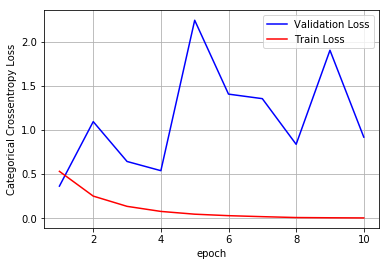

In [221]:
plot_train_cv_loss(value, epochs = 10)

### 3) 2-Layered LSTM + BatchNormalization + Dropout + sigmoid  + SGD

In [241]:
model_2 = Sequential()
model_2.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model_2.add(LSTM(10, return_sequences = True))
model_2.add(BatchNormalization())
model.add(Dropout(0.4))
model_2.add(Dense(1, activation='sigmoid'))
model_2.add(LSTM(20))
model_2.add(Dense(1, activation = 'sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 32)           64032     
_________________________________________________________________
lstm_32 (LSTM)               (None, 100, 10)           1720      
_________________________________________________________________
batch_normalization_22 (Batc (None, 100, 10)           40        
_________________________________________________________________
dense_27 (Dense)             (None, 100, 1)            11        
_________________________________________________________________
lstm_33 (LSTM)               (None, 20)                1760      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 21        
Total params: 67,584
Trainable params: 67,564
Non-trainable params: 20
_________________________________________________________________
None


In [242]:
validation_data=(x_te, y_test)
value_1 = model_2.fit(x_tr, y_train, nb_epoch=10, batch_size=64,verbose=1,validation_data=(x_te, y_test))
# Final evaluation of the model
scores = model_2.evaluate(x_te, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3490 samples, validate on 1496 samples
Epoch 1/10
3490/3490 [==============================] - ETA: 3:49 - loss: 0.6563 - acc: 0.875 - ETA: 2:05 - loss: 0.6534 - acc: 0.875 - ETA: 1:30 - loss: 0.6536 - acc: 0.854 - ETA: 1:13 - loss: 0.6535 - acc: 0.839 - ETA: 1:02 - loss: 0.6500 - acc: 0.850 - ETA: 54s - loss: 0.6488 - acc: 0.846 - ETA: 49s - loss: 0.6481 - acc: 0.83 - ETA: 45s - loss: 0.6462 - acc: 0.83 - ETA: 41s - loss: 0.6440 - acc: 0.84 - ETA: 39s - loss: 0.6425 - acc: 0.84 - ETA: 36s - loss: 0.6411 - acc: 0.83 - ETA: 34s - loss: 0.6402 - acc: 0.83 - ETA: 32s - loss: 0.6395 - acc: 0.83 - ETA: 31s - loss: 0.6359 - acc: 0.83 - ETA: 29s - loss: 0.6348 - acc: 0.83 - ETA: 28s - loss: 0.6339 - acc: 0.83 - ETA: 27s - loss: 0.6313 - acc: 0.83 - ETA: 25s - loss: 0.6298 - acc: 0.83 - ETA: 24s - loss: 0.6281 - acc: 0.83 - ETA: 23s - loss: 0.6259 - acc: 0.83 - ETA: 22s - loss: 0.6231 - acc: 0.84 - ETA: 21s - loss: 0.6214 - acc: 0.84 - ETA: 20s - loss: 0.6192 - acc: 0.84 - ETA: 20s - 

3490/3490 [==============================] - ETA: 27s - loss: 0.4859 - acc: 0.81 - ETA: 26s - loss: 0.4641 - acc: 0.82 - ETA: 25s - loss: 0.4506 - acc: 0.83 - ETA: 25s - loss: 0.4333 - acc: 0.85 - ETA: 24s - loss: 0.4227 - acc: 0.85 - ETA: 24s - loss: 0.4427 - acc: 0.84 - ETA: 23s - loss: 0.4544 - acc: 0.83 - ETA: 23s - loss: 0.4453 - acc: 0.84 - ETA: 22s - loss: 0.4358 - acc: 0.84 - ETA: 22s - loss: 0.4405 - acc: 0.84 - ETA: 21s - loss: 0.4463 - acc: 0.84 - ETA: 21s - loss: 0.4425 - acc: 0.84 - ETA: 20s - loss: 0.4343 - acc: 0.84 - ETA: 20s - loss: 0.4303 - acc: 0.85 - ETA: 19s - loss: 0.4283 - acc: 0.85 - ETA: 19s - loss: 0.4291 - acc: 0.85 - ETA: 18s - loss: 0.4299 - acc: 0.85 - ETA: 18s - loss: 0.4247 - acc: 0.85 - ETA: 17s - loss: 0.4267 - acc: 0.85 - ETA: 17s - loss: 0.4286 - acc: 0.85 - ETA: 16s - loss: 0.4302 - acc: 0.85 - ETA: 16s - loss: 0.4290 - acc: 0.85 - ETA: 15s - loss: 0.4266 - acc: 0.85 - ETA: 15s - loss: 0.4281 - acc: 0.85 - ETA: 14s - loss: 0.4268 - acc: 0.85 - ETA: 

3490/3490 [==============================] - ETA: 26s - loss: 0.4090 - acc: 0.85 - ETA: 26s - loss: 0.4113 - acc: 0.85 - ETA: 25s - loss: 0.4278 - acc: 0.84 - ETA: 25s - loss: 0.4178 - acc: 0.85 - ETA: 24s - loss: 0.4067 - acc: 0.86 - ETA: 24s - loss: 0.3988 - acc: 0.86 - ETA: 23s - loss: 0.4041 - acc: 0.86 - ETA: 23s - loss: 0.4016 - acc: 0.86 - ETA: 22s - loss: 0.4115 - acc: 0.85 - ETA: 22s - loss: 0.4212 - acc: 0.85 - ETA: 21s - loss: 0.4270 - acc: 0.84 - ETA: 21s - loss: 0.4322 - acc: 0.84 - ETA: 20s - loss: 0.4307 - acc: 0.84 - ETA: 20s - loss: 0.4255 - acc: 0.85 - ETA: 19s - loss: 0.4246 - acc: 0.85 - ETA: 19s - loss: 0.4204 - acc: 0.85 - ETA: 18s - loss: 0.4285 - acc: 0.84 - ETA: 18s - loss: 0.4203 - acc: 0.85 - ETA: 17s - loss: 0.4198 - acc: 0.85 - ETA: 17s - loss: 0.4179 - acc: 0.85 - ETA: 16s - loss: 0.4211 - acc: 0.85 - ETA: 16s - loss: 0.4228 - acc: 0.85 - ETA: 15s - loss: 0.4264 - acc: 0.84 - ETA: 15s - loss: 0.4268 - acc: 0.84 - ETA: 14s - loss: 0.4261 - acc: 0.84 - ETA: 

3490/3490 [==============================] - ETA: 26s - loss: 0.4362 - acc: 0.84 - ETA: 26s - loss: 0.4487 - acc: 0.83 - ETA: 25s - loss: 0.4268 - acc: 0.84 - ETA: 25s - loss: 0.4468 - acc: 0.83 - ETA: 24s - loss: 0.4490 - acc: 0.83 - ETA: 24s - loss: 0.4460 - acc: 0.83 - ETA: 23s - loss: 0.4338 - acc: 0.84 - ETA: 23s - loss: 0.4307 - acc: 0.84 - ETA: 22s - loss: 0.4399 - acc: 0.84 - ETA: 22s - loss: 0.4390 - acc: 0.84 - ETA: 21s - loss: 0.4478 - acc: 0.83 - ETA: 21s - loss: 0.4445 - acc: 0.83 - ETA: 20s - loss: 0.4459 - acc: 0.83 - ETA: 20s - loss: 0.4468 - acc: 0.83 - ETA: 19s - loss: 0.4510 - acc: 0.83 - ETA: 19s - loss: 0.4564 - acc: 0.83 - ETA: 18s - loss: 0.4523 - acc: 0.83 - ETA: 18s - loss: 0.4513 - acc: 0.83 - ETA: 17s - loss: 0.4544 - acc: 0.83 - ETA: 17s - loss: 0.4506 - acc: 0.83 - ETA: 16s - loss: 0.4460 - acc: 0.83 - ETA: 16s - loss: 0.4359 - acc: 0.84 - ETA: 15s - loss: 0.4357 - acc: 0.84 - ETA: 15s - loss: 0.4367 - acc: 0.84 - ETA: 14s - loss: 0.4376 - acc: 0.84 - ETA: 

In [243]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.55%


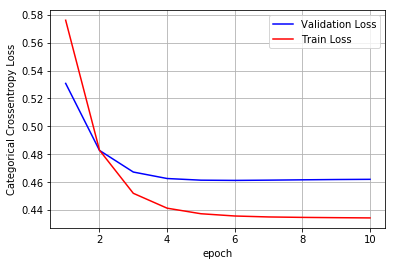

In [246]:
plot_train_cv_loss(value_1, epochs = 10)

### 4) 2-Layered LSTM + BatchNormalization +Dropouts + sigmoid + tanh + Adadelta

In [247]:
model_2 = Sequential()
model_2.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model_2.add(LSTM(40, return_sequences = True))
model_2.add(BatchNormalization())
model.add(Dropout(0.4))
model_2.add(Dense(1, activation='sigmoid'))
model_2.add(LSTM(20))
model_2.add(BatchNormalization())
model.add(Dropout(0.4))
model_2.add(Dense(1, activation = 'tanh'))
model_2.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 32)           64032     
_________________________________________________________________
lstm_34 (LSTM)               (None, 100, 40)           11680     
_________________________________________________________________
batch_normalization_23 (Batc (None, 100, 40)           160       
_________________________________________________________________
dense_29 (Dense)             (None, 100, 1)            41        
_________________________________________________________________
lstm_35 (LSTM)               (None, 20)                1760      
_________________________________________________________________
batch_normalization_24 (Batc (None, 20)                80        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 21        
Total para

In [248]:
value_1 = model_2.fit(x_tr, y_train, nb_epoch=10, batch_size=64,verbose=1,validation_data=(x_te, y_test))
# Final evaluation of the model
scores = model_2.evaluate(x_te, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3490 samples, validate on 1496 samples
Epoch 1/10
3490/3490 [==============================] - ETA: 4:37 - loss: 7.3296 - acc: 0.406 - ETA: 2:29 - loss: 6.5565 - acc: 0.359 - ETA: 1:46 - loss: 7.0138 - acc: 0.349 - ETA: 1:24 - loss: 6.8558 - acc: 0.375 - ETA: 1:11 - loss: 6.8013 - acc: 0.371 - ETA: 1:02 - loss: 6.6132 - acc: 0.385 - ETA: 55s - loss: 6.6492 - acc: 0.390 - ETA: 50s - loss: 6.7283 - acc: 0.38 - ETA: 46s - loss: 6.5549 - acc: 0.38 - ETA: 43s - loss: 6.5449 - acc: 0.38 - ETA: 40s - loss: 6.4673 - acc: 0.38 - ETA: 38s - loss: 6.3692 - acc: 0.39 - ETA: 35s - loss: 6.3558 - acc: 0.39 - ETA: 34s - loss: 6.2638 - acc: 0.39 - ETA: 32s - loss: 6.2919 - acc: 0.39 - ETA: 30s - loss: 6.2739 - acc: 0.38 - ETA: 29s - loss: 6.2521 - acc: 0.39 - ETA: 28s - loss: 6.2674 - acc: 0.39 - ETA: 26s - loss: 6.1802 - acc: 0.39 - ETA: 25s - loss: 6.1797 - acc: 0.39 - ETA: 24s - loss: 6.1633 - acc: 0.39 - ETA: 23s - loss: 6.1940 - acc: 0.39 - ETA: 22s - loss: 6.1912 - acc: 0.39 - ETA: 21s 

3490/3490 [==============================] - ETA: 27s - loss: 2.3788 - acc: 0.57 - ETA: 27s - loss: 2.0195 - acc: 0.62 - ETA: 26s - loss: 1.9674 - acc: 0.60 - ETA: 26s - loss: 2.0789 - acc: 0.60 - ETA: 25s - loss: 2.0406 - acc: 0.59 - ETA: 24s - loss: 1.9055 - acc: 0.59 - ETA: 24s - loss: 1.8722 - acc: 0.59 - ETA: 23s - loss: 1.8246 - acc: 0.58 - ETA: 23s - loss: 1.8275 - acc: 0.58 - ETA: 22s - loss: 1.9732 - acc: 0.58 - ETA: 22s - loss: 1.8777 - acc: 0.58 - ETA: 21s - loss: 1.8256 - acc: 0.58 - ETA: 21s - loss: 1.8131 - acc: 0.58 - ETA: 20s - loss: 1.8089 - acc: 0.58 - ETA: 20s - loss: 1.8257 - acc: 0.58 - ETA: 19s - loss: 1.7709 - acc: 0.59 - ETA: 19s - loss: 1.7186 - acc: 0.59 - ETA: 18s - loss: 1.7275 - acc: 0.59 - ETA: 18s - loss: 1.7614 - acc: 0.59 - ETA: 17s - loss: 1.7611 - acc: 0.59 - ETA: 17s - loss: 1.7458 - acc: 0.59 - ETA: 16s - loss: 1.7548 - acc: 0.59 - ETA: 16s - loss: 1.7462 - acc: 0.59 - ETA: 15s - loss: 1.7594 - acc: 0.59 - ETA: 15s - loss: 1.7405 - acc: 0.59 - ETA: 

3490/3490 [==============================] - ETA: 26s - loss: 0.4660 - acc: 0.89 - ETA: 26s - loss: 0.4918 - acc: 0.82 - ETA: 25s - loss: 0.4698 - acc: 0.86 - ETA: 25s - loss: 0.4772 - acc: 0.84 - ETA: 24s - loss: 0.4704 - acc: 0.85 - ETA: 24s - loss: 0.4706 - acc: 0.85 - ETA: 24s - loss: 0.4707 - acc: 0.85 - ETA: 23s - loss: 0.4676 - acc: 0.85 - ETA: 23s - loss: 0.4619 - acc: 0.86 - ETA: 22s - loss: 0.4584 - acc: 0.87 - ETA: 21s - loss: 0.4589 - acc: 0.87 - ETA: 21s - loss: 0.4616 - acc: 0.86 - ETA: 20s - loss: 0.4573 - acc: 0.86 - ETA: 20s - loss: 0.4582 - acc: 0.86 - ETA: 19s - loss: 0.4571 - acc: 0.86 - ETA: 19s - loss: 0.4567 - acc: 0.86 - ETA: 18s - loss: 0.4681 - acc: 0.86 - ETA: 18s - loss: 0.4654 - acc: 0.86 - ETA: 17s - loss: 0.4627 - acc: 0.86 - ETA: 17s - loss: 0.4604 - acc: 0.86 - ETA: 16s - loss: 0.4577 - acc: 0.86 - ETA: 16s - loss: 0.4652 - acc: 0.86 - ETA: 15s - loss: 0.4619 - acc: 0.86 - ETA: 15s - loss: 0.4605 - acc: 0.86 - ETA: 14s - loss: 0.4579 - acc: 0.86 - ETA: 

3490/3490 [==============================] - ETA: 27s - loss: 0.2269 - acc: 0.92 - ETA: 26s - loss: 0.2259 - acc: 0.92 - ETA: 26s - loss: 0.2316 - acc: 0.93 - ETA: 25s - loss: 0.2184 - acc: 0.94 - ETA: 25s - loss: 0.2698 - acc: 0.93 - ETA: 24s - loss: 0.2664 - acc: 0.92 - ETA: 24s - loss: 0.2581 - acc: 0.92 - ETA: 23s - loss: 0.2449 - acc: 0.92 - ETA: 23s - loss: 0.2474 - acc: 0.92 - ETA: 22s - loss: 0.2440 - acc: 0.92 - ETA: 22s - loss: 0.2418 - acc: 0.93 - ETA: 21s - loss: 0.2391 - acc: 0.93 - ETA: 20s - loss: 0.2388 - acc: 0.93 - ETA: 20s - loss: 0.2387 - acc: 0.92 - ETA: 19s - loss: 0.2371 - acc: 0.92 - ETA: 19s - loss: 0.2350 - acc: 0.92 - ETA: 19s - loss: 0.2356 - acc: 0.93 - ETA: 18s - loss: 0.2359 - acc: 0.93 - ETA: 17s - loss: 0.2350 - acc: 0.93 - ETA: 17s - loss: 0.2327 - acc: 0.93 - ETA: 17s - loss: 0.2314 - acc: 0.93 - ETA: 16s - loss: 0.2308 - acc: 0.93 - ETA: 16s - loss: 0.2297 - acc: 0.93 - ETA: 15s - loss: 0.2309 - acc: 0.93 - ETA: 14s - loss: 0.2300 - acc: 0.93 - ETA: 

In [249]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.62%


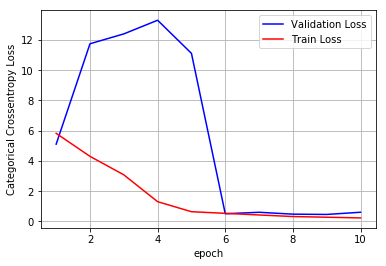

In [250]:
plot_train_cv_loss(value_1, epochs = 10)

### 5) 2-Layered LSTM + BatchNormalization + sigmoid + Adam

In [226]:
model_2 = Sequential()
model_2.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model_2.add(LSTM(20, return_sequences = True))
model_2.add(BatchNormalization())
model_2.add(Dense(1, activation='sigmoid'))
model_2.add(LSTM(50))
model_2.add(BatchNormalization())
model_2.add(Dense(1, activation = 'sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 32)           64032     
_________________________________________________________________
lstm_15 (LSTM)               (None, 100, 20)           4240      
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 20)           80        
_________________________________________________________________
dense_16 (Dense)             (None, 100, 1)            21        
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                10400     
_________________________________________________________________
batch_normalization_7 (Batch (None, 50)                200       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total para

In [227]:
test = model_2.fit(x_tr, y_train, nb_epoch=10, batch_size=64,verbose=1,validation_data=(x_te, y_test))
# Final evaluation of the model
scores = model_2.evaluate(x_te, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3490 samples, validate on 1496 samples
Epoch 1/10
3490/3490 [==============================] - ETA: 3:12 - loss: 0.6962 - acc: 0.375 - ETA: 1:49 - loss: 0.6937 - acc: 0.476 - ETA: 1:23 - loss: 0.6921 - acc: 0.510 - ETA: 1:08 - loss: 0.6907 - acc: 0.523 - ETA: 1:00 - loss: 0.6890 - acc: 0.528 - ETA: 54s - loss: 0.6872 - acc: 0.549 - ETA: 50s - loss: 0.6853 - acc: 0.58 - ETA: 46s - loss: 0.6838 - acc: 0.60 - ETA: 45s - loss: 0.6815 - acc: 0.63 - ETA: 43s - loss: 0.6798 - acc: 0.64 - ETA: 40s - loss: 0.6780 - acc: 0.65 - ETA: 38s - loss: 0.6761 - acc: 0.65 - ETA: 36s - loss: 0.6744 - acc: 0.65 - ETA: 34s - loss: 0.6718 - acc: 0.65 - ETA: 32s - loss: 0.6696 - acc: 0.65 - ETA: 31s - loss: 0.6681 - acc: 0.65 - ETA: 29s - loss: 0.6652 - acc: 0.65 - ETA: 28s - loss: 0.6636 - acc: 0.65 - ETA: 27s - loss: 0.6614 - acc: 0.65 - ETA: 26s - loss: 0.6591 - acc: 0.66 - ETA: 25s - loss: 0.6569 - acc: 0.66 - ETA: 24s - loss: 0.6567 - acc: 0.66 - ETA: 23s - loss: 0.6545 - acc: 0.66 - ETA: 23s - 

3490/3490 [==============================] - ETA: 28s - loss: 0.0909 - acc: 0.98 - ETA: 28s - loss: 0.0638 - acc: 0.99 - ETA: 27s - loss: 0.0564 - acc: 0.99 - ETA: 26s - loss: 0.0630 - acc: 0.99 - ETA: 27s - loss: 0.0673 - acc: 0.98 - ETA: 30s - loss: 0.0724 - acc: 0.98 - ETA: 29s - loss: 0.0711 - acc: 0.98 - ETA: 29s - loss: 0.0741 - acc: 0.98 - ETA: 28s - loss: 0.0759 - acc: 0.98 - ETA: 27s - loss: 0.0778 - acc: 0.98 - ETA: 26s - loss: 0.0738 - acc: 0.98 - ETA: 25s - loss: 0.0728 - acc: 0.98 - ETA: 24s - loss: 0.0703 - acc: 0.98 - ETA: 25s - loss: 0.0727 - acc: 0.98 - ETA: 25s - loss: 0.0716 - acc: 0.98 - ETA: 26s - loss: 0.0727 - acc: 0.98 - ETA: 25s - loss: 0.0759 - acc: 0.98 - ETA: 25s - loss: 0.0753 - acc: 0.98 - ETA: 24s - loss: 0.0738 - acc: 0.98 - ETA: 23s - loss: 0.0756 - acc: 0.98 - ETA: 22s - loss: 0.0783 - acc: 0.98 - ETA: 21s - loss: 0.0797 - acc: 0.98 - ETA: 21s - loss: 0.0784 - acc: 0.98 - ETA: 21s - loss: 0.0786 - acc: 0.98 - ETA: 20s - loss: 0.0793 - acc: 0.98 - ETA: 

3490/3490 [==============================] - ETA: 28s - loss: 0.0111 - acc: 1.00 - ETA: 27s - loss: 0.0091 - acc: 1.00 - ETA: 27s - loss: 0.0082 - acc: 1.00 - ETA: 26s - loss: 0.0096 - acc: 1.00 - ETA: 26s - loss: 0.0101 - acc: 1.00 - ETA: 25s - loss: 0.0101 - acc: 1.00 - ETA: 25s - loss: 0.0101 - acc: 1.00 - ETA: 24s - loss: 0.0094 - acc: 1.00 - ETA: 25s - loss: 0.0107 - acc: 1.00 - ETA: 26s - loss: 0.0108 - acc: 1.00 - ETA: 26s - loss: 0.0113 - acc: 1.00 - ETA: 27s - loss: 0.0108 - acc: 1.00 - ETA: 27s - loss: 0.0103 - acc: 1.00 - ETA: 28s - loss: 0.0099 - acc: 1.00 - ETA: 28s - loss: 0.0095 - acc: 1.00 - ETA: 28s - loss: 0.0095 - acc: 1.00 - ETA: 28s - loss: 0.0095 - acc: 1.00 - ETA: 28s - loss: 0.0093 - acc: 1.00 - ETA: 27s - loss: 0.0090 - acc: 1.00 - ETA: 27s - loss: 0.0090 - acc: 1.00 - ETA: 26s - loss: 0.0088 - acc: 1.00 - ETA: 25s - loss: 0.0091 - acc: 1.00 - ETA: 24s - loss: 0.0088 - acc: 1.00 - ETA: 24s - loss: 0.0097 - acc: 0.99 - ETA: 22s - loss: 0.0095 - acc: 0.99 - ETA: 

3490/3490 [==============================] - ETA: 27s - loss: 0.0037 - acc: 1.00 - ETA: 27s - loss: 0.0030 - acc: 1.00 - ETA: 35s - loss: 0.0023 - acc: 1.00 - ETA: 41s - loss: 0.0020 - acc: 1.00 - ETA: 38s - loss: 0.0024 - acc: 1.00 - ETA: 39s - loss: 0.0021 - acc: 1.00 - ETA: 36s - loss: 0.0018 - acc: 1.00 - ETA: 34s - loss: 0.0017 - acc: 1.00 - ETA: 32s - loss: 0.0016 - acc: 1.00 - ETA: 31s - loss: 0.0016 - acc: 1.00 - ETA: 31s - loss: 0.0040 - acc: 0.99 - ETA: 30s - loss: 0.0037 - acc: 0.99 - ETA: 30s - loss: 0.0036 - acc: 0.99 - ETA: 29s - loss: 0.0034 - acc: 0.99 - ETA: 29s - loss: 0.0034 - acc: 0.99 - ETA: 28s - loss: 0.0033 - acc: 0.99 - ETA: 27s - loss: 0.0031 - acc: 0.99 - ETA: 27s - loss: 0.0031 - acc: 0.99 - ETA: 27s - loss: 0.0030 - acc: 0.99 - ETA: 25s - loss: 0.0029 - acc: 0.99 - ETA: 24s - loss: 0.0029 - acc: 0.99 - ETA: 23s - loss: 0.0029 - acc: 0.99 - ETA: 22s - loss: 0.0029 - acc: 0.99 - ETA: 21s - loss: 0.0029 - acc: 0.99 - ETA: 20s - loss: 0.0028 - acc: 0.99 - ETA: 

In [228]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.70%


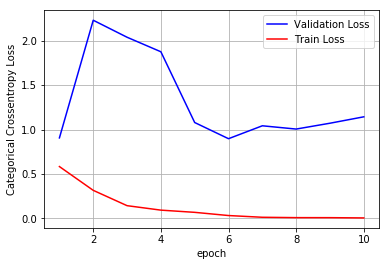

In [229]:
plot_train_cv_loss(test, epochs = 10)

### 6) 5-Layered LSTM + BatchNormalization + tanh + sigmoid + SGD

In [230]:
model_3 = Sequential()
model_3.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model_3.add(LSTM(20, return_sequences = True))
model_3.add(BatchNormalization())
model_3.add(Dense(1, activation='tanh'))
model_3.add(LSTM(50,return_sequences = True))
model_3.add(BatchNormalization())
model_3.add(Dense(1, activation = 'sigmoid'))
model_3.add(LSTM(10,return_sequences = True))
model_3.add(BatchNormalization())
model_3.add(LSTM(50,return_sequences = True))
model_3.add(BatchNormalization())
model_3.add(LSTM(10))
model_3.add(BatchNormalization())
model_3.add(Dense(1, activation = 'sigmoid'))
model_3.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 32)           64032     
_________________________________________________________________
lstm_17 (LSTM)               (None, 100, 20)           4240      
_________________________________________________________________
batch_normalization_8 (Batch (None, 100, 20)           80        
_________________________________________________________________
dense_18 (Dense)             (None, 100, 1)            21        
_________________________________________________________________
lstm_18 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
batch_normalization_9 (Batch (None, 100, 50)           200       
_________________________________________________________________
dense_19 (Dense)             (None, 100, 1)            51        
__________

In [231]:
output = model_3.fit(x_tr, y_train, nb_epoch=10, batch_size=64,verbose=1,validation_data=(x_te, y_test))
# Final evaluation of the model
scores = model_3.evaluate(x_te, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3490 samples, validate on 1496 samples
Epoch 1/10
3490/3490 [==============================] - ETA: 7:29 - loss: 0.7516 - acc: 0.750 - ETA: 4:29 - loss: 0.7691 - acc: 0.664 - ETA: 3:24 - loss: 0.7774 - acc: 0.640 - ETA: 2:49 - loss: 0.7608 - acc: 0.640 - ETA: 2:25 - loss: 0.7483 - acc: 0.637 - ETA: 2:09 - loss: 0.7428 - acc: 0.651 - ETA: 1:57 - loss: 0.7372 - acc: 0.633 - ETA: 1:51 - loss: 0.7284 - acc: 0.646 - ETA: 1:46 - loss: 0.7240 - acc: 0.638 - ETA: 1:39 - loss: 0.7226 - acc: 0.654 - ETA: 1:33 - loss: 0.7181 - acc: 0.656 - ETA: 1:31 - loss: 0.7137 - acc: 0.666 - ETA: 1:28 - loss: 0.7099 - acc: 0.676 - ETA: 1:28 - loss: 0.7065 - acc: 0.683 - ETA: 1:26 - loss: 0.7052 - acc: 0.676 - ETA: 1:24 - loss: 0.7029 - acc: 0.680 - ETA: 1:22 - loss: 0.7004 - acc: 0.688 - ETA: 1:18 - loss: 0.6974 - acc: 0.695 - ETA: 1:14 - loss: 0.6947 - acc: 0.698 - ETA: 1:11 - loss: 0.6920 - acc: 0.703 - ETA: 1:09 - loss: 0.6891 - acc: 0.712 - ETA: 1:06 - loss: 0.6875 - acc: 0.707 - ETA: 1:03 - loss

3490/3490 [==============================] - ETA: 2:11 - loss: 0.5117 - acc: 0.828 - ETA: 1:55 - loss: 0.4950 - acc: 0.835 - ETA: 1:55 - loss: 0.4709 - acc: 0.859 - ETA: 1:41 - loss: 0.4654 - acc: 0.863 - ETA: 1:32 - loss: 0.4549 - acc: 0.871 - ETA: 1:28 - loss: 0.4497 - acc: 0.880 - ETA: 1:27 - loss: 0.4651 - acc: 0.859 - ETA: 1:25 - loss: 0.4772 - acc: 0.845 - ETA: 1:27 - loss: 0.4812 - acc: 0.842 - ETA: 1:25 - loss: 0.4816 - acc: 0.839 - ETA: 1:22 - loss: 0.4848 - acc: 0.835 - ETA: 1:21 - loss: 0.4788 - acc: 0.839 - ETA: 1:19 - loss: 0.4773 - acc: 0.841 - ETA: 1:17 - loss: 0.4797 - acc: 0.838 - ETA: 1:17 - loss: 0.4853 - acc: 0.831 - ETA: 1:15 - loss: 0.4866 - acc: 0.831 - ETA: 1:14 - loss: 0.4902 - acc: 0.826 - ETA: 1:12 - loss: 0.4854 - acc: 0.831 - ETA: 1:10 - loss: 0.4855 - acc: 0.831 - ETA: 1:08 - loss: 0.4853 - acc: 0.830 - ETA: 1:06 - loss: 0.4846 - acc: 0.831 - ETA: 1:03 - loss: 0.4826 - acc: 0.833 - ETA: 1:00 - loss: 0.4832 - acc: 0.832 - ETA: 57s - loss: 0.4845 - acc: 0.83

3490/3490 [==============================] - ETA: 1:51 - loss: 0.4989 - acc: 0.796 - ETA: 1:43 - loss: 0.4846 - acc: 0.804 - ETA: 1:30 - loss: 0.4762 - acc: 0.817 - ETA: 1:22 - loss: 0.4681 - acc: 0.824 - ETA: 1:17 - loss: 0.4675 - acc: 0.825 - ETA: 1:14 - loss: 0.4698 - acc: 0.825 - ETA: 1:18 - loss: 0.4692 - acc: 0.823 - ETA: 1:20 - loss: 0.4700 - acc: 0.820 - ETA: 1:16 - loss: 0.4649 - acc: 0.822 - ETA: 1:12 - loss: 0.4550 - acc: 0.829 - ETA: 1:11 - loss: 0.4650 - acc: 0.821 - ETA: 1:11 - loss: 0.4656 - acc: 0.822 - ETA: 1:10 - loss: 0.4642 - acc: 0.823 - ETA: 1:11 - loss: 0.4634 - acc: 0.824 - ETA: 1:10 - loss: 0.4590 - acc: 0.827 - ETA: 1:08 - loss: 0.4524 - acc: 0.832 - ETA: 1:08 - loss: 0.4499 - acc: 0.834 - ETA: 1:06 - loss: 0.4460 - acc: 0.837 - ETA: 1:06 - loss: 0.4483 - acc: 0.835 - ETA: 1:03 - loss: 0.4477 - acc: 0.835 - ETA: 1:00 - loss: 0.4435 - acc: 0.838 - ETA: 58s - loss: 0.4403 - acc: 0.840 - ETA: 55s - loss: 0.4445 - acc: 0.83 - ETA: 53s - loss: 0.4458 - acc: 0.83 - 

3490/3490 [==============================] - ETA: 1:06 - loss: 0.3155 - acc: 0.921 - ETA: 1:04 - loss: 0.3511 - acc: 0.898 - ETA: 1:03 - loss: 0.3532 - acc: 0.895 - ETA: 1:02 - loss: 0.3930 - acc: 0.867 - ETA: 1:00 - loss: 0.3889 - acc: 0.865 - ETA: 59s - loss: 0.3966 - acc: 0.856 - ETA: 58s - loss: 0.4070 - acc: 0.84 - ETA: 57s - loss: 0.3994 - acc: 0.85 - ETA: 55s - loss: 0.3878 - acc: 0.85 - ETA: 54s - loss: 0.3808 - acc: 0.86 - ETA: 53s - loss: 0.3812 - acc: 0.86 - ETA: 52s - loss: 0.3861 - acc: 0.85 - ETA: 50s - loss: 0.3942 - acc: 0.85 - ETA: 49s - loss: 0.3914 - acc: 0.85 - ETA: 48s - loss: 0.3939 - acc: 0.85 - ETA: 47s - loss: 0.3962 - acc: 0.85 - ETA: 45s - loss: 0.3998 - acc: 0.85 - ETA: 44s - loss: 0.4052 - acc: 0.84 - ETA: 43s - loss: 0.4043 - acc: 0.84 - ETA: 42s - loss: 0.3982 - acc: 0.85 - ETA: 41s - loss: 0.4053 - acc: 0.84 - ETA: 39s - loss: 0.4057 - acc: 0.84 - ETA: 38s - loss: 0.4008 - acc: 0.84 - ETA: 37s - loss: 0.4018 - acc: 0.84 - ETA: 36s - loss: 0.4001 - acc: 0

In [232]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.55%


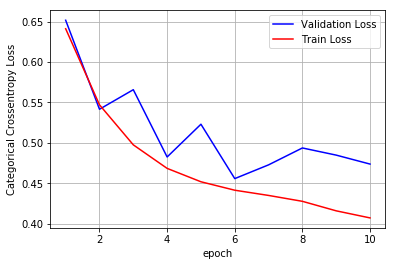

In [233]:
plot_train_cv_loss(output, epochs = 10)

### 7) 5-Layered LSTM + Dropouts  + sigmoid + Adagrad

In [234]:
model_3 = Sequential()
model_3.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model_3.add(LSTM(5, return_sequences = True))
model.add(Dropout(0.4))
model_3.add(Dense(1, activation='sigmoid'))
model_3.add(LSTM(10,return_sequences = True))
model.add(Dropout(0.7))
model_3.add(BatchNormalization())
model_3.add(Dense(1, activation = 'sigmoid'))
model_3.add(LSTM(15,return_sequences = True))
model_3.add(BatchNormalization())
model_3.add(LSTM(20,return_sequences = True))
model.add(Dropout(0.3))
model_3.add(BatchNormalization())
model_3.add(LSTM(30))
model_3.add(BatchNormalization())
model_3.add(Dense(1, activation = 'sigmoid'))
model_3.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 32)           64032     
_________________________________________________________________
lstm_22 (LSTM)               (None, 100, 5)            760       
_________________________________________________________________
dense_21 (Dense)             (None, 100, 1)            6         
_________________________________________________________________
lstm_23 (LSTM)               (None, 100, 10)           480       
_________________________________________________________________
batch_normalization_13 (Batc (None, 100, 10)           40        
_________________________________________________________________
dense_22 (Dense)             (None, 100, 1)            11        
_________________________________________________________________
lstm_24 (LSTM)               (None, 100, 15)           1020      
__________

In [235]:
output_1 = model_3.fit(x_tr, y_train, nb_epoch=10, batch_size=64,verbose=1,validation_data=(x_te, y_test))
# Final evaluation of the model
scores = model_3.evaluate(x_te, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3490 samples, validate on 1496 samples
Epoch 1/10
3490/3490 [==============================] - ETA: 5:50 - loss: 0.8558 - acc: 0.515 - ETA: 3:25 - loss: 0.8108 - acc: 0.476 - ETA: 2:35 - loss: 0.8107 - acc: 0.463 - ETA: 2:09 - loss: 0.7852 - acc: 0.511 - ETA: 1:53 - loss: 0.7699 - acc: 0.521 - ETA: 1:43 - loss: 0.7652 - acc: 0.513 - ETA: 1:34 - loss: 0.7434 - acc: 0.542 - ETA: 1:28 - loss: 0.7289 - acc: 0.562 - ETA: 1:23 - loss: 0.7179 - acc: 0.578 - ETA: 1:19 - loss: 0.7114 - acc: 0.585 - ETA: 1:15 - loss: 0.6982 - acc: 0.605 - ETA: 1:11 - loss: 0.6898 - acc: 0.615 - ETA: 1:08 - loss: 0.6817 - acc: 0.628 - ETA: 1:05 - loss: 0.6740 - acc: 0.641 - ETA: 1:03 - loss: 0.6664 - acc: 0.651 - ETA: 1:00 - loss: 0.6601 - acc: 0.663 - ETA: 58s - loss: 0.6564 - acc: 0.667 - ETA: 56s - loss: 0.6495 - acc: 0.67 - ETA: 54s - loss: 0.6442 - acc: 0.68 - ETA: 52s - loss: 0.6397 - acc: 0.69 - ETA: 50s - loss: 0.6353 - acc: 0.70 - ETA: 48s - loss: 0.6304 - acc: 0.71 - ETA: 46s - loss: 0.6262 - a

3490/3490 [==============================] - ETA: 1:07 - loss: 0.2013 - acc: 0.937 - ETA: 1:05 - loss: 0.1770 - acc: 0.953 - ETA: 1:04 - loss: 0.1577 - acc: 0.963 - ETA: 1:03 - loss: 0.1698 - acc: 0.960 - ETA: 1:02 - loss: 0.1739 - acc: 0.956 - ETA: 1:00 - loss: 0.1688 - acc: 0.955 - ETA: 59s - loss: 0.1755 - acc: 0.946 - ETA: 58s - loss: 0.1720 - acc: 0.94 - ETA: 56s - loss: 0.1689 - acc: 0.95 - ETA: 55s - loss: 0.1668 - acc: 0.95 - ETA: 54s - loss: 0.1673 - acc: 0.95 - ETA: 53s - loss: 0.1638 - acc: 0.95 - ETA: 51s - loss: 0.1633 - acc: 0.95 - ETA: 50s - loss: 0.1653 - acc: 0.95 - ETA: 49s - loss: 0.1698 - acc: 0.95 - ETA: 48s - loss: 0.1649 - acc: 0.95 - ETA: 46s - loss: 0.1672 - acc: 0.95 - ETA: 45s - loss: 0.1646 - acc: 0.95 - ETA: 44s - loss: 0.1613 - acc: 0.95 - ETA: 43s - loss: 0.1605 - acc: 0.95 - ETA: 41s - loss: 0.1590 - acc: 0.95 - ETA: 40s - loss: 0.1589 - acc: 0.96 - ETA: 39s - loss: 0.1579 - acc: 0.96 - ETA: 38s - loss: 0.1566 - acc: 0.96 - ETA: 36s - loss: 0.1573 - acc:

3490/3490 [==============================] - ETA: 1:07 - loss: 0.0264 - acc: 1.000 - ETA: 1:05 - loss: 0.0244 - acc: 1.000 - ETA: 1:04 - loss: 0.0271 - acc: 1.000 - ETA: 1:02 - loss: 0.0483 - acc: 0.996 - ETA: 1:01 - loss: 0.0430 - acc: 0.996 - ETA: 1:00 - loss: 0.0503 - acc: 0.994 - ETA: 58s - loss: 0.0568 - acc: 0.993 - ETA: 57s - loss: 0.0530 - acc: 0.99 - ETA: 56s - loss: 0.0520 - acc: 0.99 - ETA: 55s - loss: 0.0494 - acc: 0.99 - ETA: 54s - loss: 0.0509 - acc: 0.99 - ETA: 52s - loss: 0.0485 - acc: 0.99 - ETA: 51s - loss: 0.0537 - acc: 0.99 - ETA: 50s - loss: 0.0518 - acc: 0.99 - ETA: 49s - loss: 0.0535 - acc: 0.99 - ETA: 47s - loss: 0.0517 - acc: 0.99 - ETA: 46s - loss: 0.0507 - acc: 0.99 - ETA: 45s - loss: 0.0535 - acc: 0.99 - ETA: 44s - loss: 0.0518 - acc: 0.99 - ETA: 42s - loss: 0.0532 - acc: 0.99 - ETA: 41s - loss: 0.0521 - acc: 0.99 - ETA: 40s - loss: 0.0507 - acc: 0.99 - ETA: 39s - loss: 0.0493 - acc: 0.99 - ETA: 37s - loss: 0.0518 - acc: 0.99 - ETA: 36s - loss: 0.0508 - acc:

3490/3490 [==============================] - ETA: 1:06 - loss: 0.0166 - acc: 1.000 - ETA: 1:05 - loss: 0.0141 - acc: 1.000 - ETA: 1:04 - loss: 0.0146 - acc: 1.000 - ETA: 1:02 - loss: 0.0143 - acc: 1.000 - ETA: 1:01 - loss: 0.0249 - acc: 0.996 - ETA: 59s - loss: 0.0365 - acc: 0.994 - ETA: 58s - loss: 0.0341 - acc: 0.99 - ETA: 57s - loss: 0.0450 - acc: 0.99 - ETA: 56s - loss: 0.0475 - acc: 0.99 - ETA: 55s - loss: 0.0455 - acc: 0.99 - ETA: 53s - loss: 0.0529 - acc: 0.99 - ETA: 52s - loss: 0.0549 - acc: 0.98 - ETA: 51s - loss: 0.0515 - acc: 0.99 - ETA: 50s - loss: 0.0488 - acc: 0.99 - ETA: 48s - loss: 0.0471 - acc: 0.99 - ETA: 47s - loss: 0.0531 - acc: 0.99 - ETA: 46s - loss: 0.0509 - acc: 0.99 - ETA: 45s - loss: 0.0509 - acc: 0.99 - ETA: 43s - loss: 0.0498 - acc: 0.99 - ETA: 42s - loss: 0.0513 - acc: 0.99 - ETA: 41s - loss: 0.0497 - acc: 0.99 - ETA: 40s - loss: 0.0489 - acc: 0.99 - ETA: 39s - loss: 0.0505 - acc: 0.99 - ETA: 37s - loss: 0.0490 - acc: 0.99 - ETA: 36s - loss: 0.0503 - acc: 0

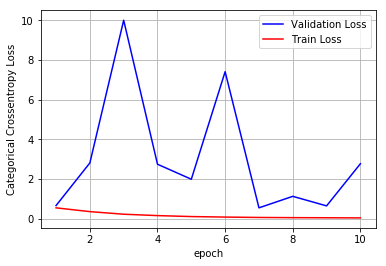

In [236]:
plot_train_cv_loss(output_1, epochs = 10)

### 8) 5-Layered LSTM + BatchNormalization + sigmoid + Adam

In [237]:
model_3 = Sequential()
model_3.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model_3.add(LSTM(50, return_sequences = True))
model_3.add(BatchNormalization())
model_3.add(Dense(1, activation='sigmoid'))
model_3.add(LSTM(40,return_sequences = True))
model_3.add(BatchNormalization())
model_3.add(Dense(1, activation = 'sigmoid'))
model_3.add(LSTM(30,return_sequences = True))
model_3.add(BatchNormalization())
model_3.add(LSTM(20,return_sequences = True))
model_3.add(BatchNormalization())
model_3.add(LSTM(10))
model_3.add(BatchNormalization())
model_3.add(Dense(1, activation = 'sigmoid'))
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 32)           64032     
_________________________________________________________________
lstm_27 (LSTM)               (None, 100, 50)           16600     
_________________________________________________________________
batch_normalization_17 (Batc (None, 100, 50)           200       
_________________________________________________________________
dense_24 (Dense)             (None, 100, 1)            51        
_________________________________________________________________
lstm_28 (LSTM)               (None, 100, 40)           6720      
_________________________________________________________________
batch_normalization_18 (Batc (None, 100, 40)           160       
_________________________________________________________________
dense_25 (Dense)             (None, 100, 1)            41        
__________

In [238]:
output_2 = model_3.fit(x_tr, y_train, nb_epoch=10, batch_size=64,verbose=1,validation_data=(x_te, y_test))
# Final evaluation of the model
scores = model_3.evaluate(x_te, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3490 samples, validate on 1496 samples
Epoch 1/10
3490/3490 [==============================] - ETA: 6:50 - loss: 0.9135 - acc: 0.421 - ETA: 3:54 - loss: 0.8351 - acc: 0.421 - ETA: 2:54 - loss: 0.7957 - acc: 0.442 - ETA: 2:24 - loss: 0.7775 - acc: 0.492 - ETA: 2:05 - loss: 0.7675 - acc: 0.509 - ETA: 1:53 - loss: 0.7648 - acc: 0.513 - ETA: 1:46 - loss: 0.7588 - acc: 0.497 - ETA: 1:39 - loss: 0.7509 - acc: 0.507 - ETA: 1:33 - loss: 0.7490 - acc: 0.506 - ETA: 1:28 - loss: 0.7457 - acc: 0.514 - ETA: 1:23 - loss: 0.7403 - acc: 0.531 - ETA: 1:19 - loss: 0.7372 - acc: 0.537 - ETA: 1:15 - loss: 0.7317 - acc: 0.549 - ETA: 1:12 - loss: 0.7266 - acc: 0.558 - ETA: 1:09 - loss: 0.7218 - acc: 0.561 - ETA: 1:06 - loss: 0.7181 - acc: 0.567 - ETA: 1:03 - loss: 0.7141 - acc: 0.572 - ETA: 1:01 - loss: 0.7105 - acc: 0.572 - ETA: 58s - loss: 0.7079 - acc: 0.572 - ETA: 56s - loss: 0.7045 - acc: 0.57 - ETA: 54s - loss: 0.7020 - acc: 0.57 - ETA: 52s - loss: 0.6992 - acc: 0.57 - ETA: 50s - loss: 0.6964

3490/3490 [==============================] - ETA: 1:07 - loss: 0.2139 - acc: 0.937 - ETA: 1:05 - loss: 0.2040 - acc: 0.945 - ETA: 1:04 - loss: 0.1988 - acc: 0.937 - ETA: 1:03 - loss: 0.2074 - acc: 0.941 - ETA: 1:01 - loss: 0.2139 - acc: 0.940 - ETA: 1:00 - loss: 0.2139 - acc: 0.942 - ETA: 59s - loss: 0.2012 - acc: 0.948 - ETA: 57s - loss: 0.2009 - acc: 0.94 - ETA: 56s - loss: 0.2023 - acc: 0.94 - ETA: 55s - loss: 0.2057 - acc: 0.94 - ETA: 54s - loss: 0.2030 - acc: 0.95 - ETA: 53s - loss: 0.2036 - acc: 0.95 - ETA: 51s - loss: 0.2123 - acc: 0.94 - ETA: 50s - loss: 0.2096 - acc: 0.94 - ETA: 49s - loss: 0.2119 - acc: 0.94 - ETA: 48s - loss: 0.2081 - acc: 0.95 - ETA: 46s - loss: 0.2068 - acc: 0.95 - ETA: 45s - loss: 0.2038 - acc: 0.95 - ETA: 44s - loss: 0.1997 - acc: 0.95 - ETA: 43s - loss: 0.1986 - acc: 0.95 - ETA: 41s - loss: 0.1931 - acc: 0.95 - ETA: 40s - loss: 0.1899 - acc: 0.95 - ETA: 39s - loss: 0.1864 - acc: 0.95 - ETA: 38s - loss: 0.1827 - acc: 0.95 - ETA: 36s - loss: 0.1913 - acc:

3490/3490 [==============================] - ETA: 1:06 - loss: 0.0730 - acc: 0.984 - ETA: 1:05 - loss: 0.0470 - acc: 0.992 - ETA: 1:04 - loss: 0.0545 - acc: 0.989 - ETA: 1:02 - loss: 0.0535 - acc: 0.992 - ETA: 1:01 - loss: 0.0601 - acc: 0.987 - ETA: 1:00 - loss: 0.0753 - acc: 0.984 - ETA: 58s - loss: 0.0757 - acc: 0.982 - ETA: 57s - loss: 0.0793 - acc: 0.98 - ETA: 56s - loss: 0.0931 - acc: 0.97 - ETA: 55s - loss: 0.0918 - acc: 0.97 - ETA: 54s - loss: 0.0922 - acc: 0.98 - ETA: 52s - loss: 0.0962 - acc: 0.97 - ETA: 51s - loss: 0.0932 - acc: 0.97 - ETA: 50s - loss: 0.0894 - acc: 0.97 - ETA: 48s - loss: 0.0864 - acc: 0.98 - ETA: 47s - loss: 0.0882 - acc: 0.97 - ETA: 46s - loss: 0.0849 - acc: 0.98 - ETA: 45s - loss: 0.0846 - acc: 0.98 - ETA: 44s - loss: 0.0815 - acc: 0.98 - ETA: 42s - loss: 0.0831 - acc: 0.98 - ETA: 41s - loss: 0.0839 - acc: 0.98 - ETA: 40s - loss: 0.0837 - acc: 0.98 - ETA: 39s - loss: 0.0861 - acc: 0.97 - ETA: 37s - loss: 0.0845 - acc: 0.97 - ETA: 36s - loss: 0.0821 - acc:

3490/3490 [==============================] - ETA: 1:07 - loss: 0.0204 - acc: 1.000 - ETA: 1:05 - loss: 0.0275 - acc: 1.000 - ETA: 1:04 - loss: 0.0244 - acc: 1.000 - ETA: 1:03 - loss: 0.0341 - acc: 0.996 - ETA: 1:02 - loss: 0.0293 - acc: 0.996 - ETA: 1:01 - loss: 0.0292 - acc: 0.994 - ETA: 59s - loss: 0.0278 - acc: 0.995 - ETA: 58s - loss: 0.0263 - acc: 0.99 - ETA: 57s - loss: 0.0408 - acc: 0.99 - ETA: 55s - loss: 0.0382 - acc: 0.99 - ETA: 54s - loss: 0.0417 - acc: 0.99 - ETA: 53s - loss: 0.0388 - acc: 0.99 - ETA: 52s - loss: 0.0367 - acc: 0.99 - ETA: 50s - loss: 0.0375 - acc: 0.99 - ETA: 49s - loss: 0.0402 - acc: 0.99 - ETA: 48s - loss: 0.0419 - acc: 0.99 - ETA: 46s - loss: 0.0444 - acc: 0.99 - ETA: 45s - loss: 0.0451 - acc: 0.99 - ETA: 44s - loss: 0.0432 - acc: 0.99 - ETA: 43s - loss: 0.0420 - acc: 0.99 - ETA: 41s - loss: 0.0452 - acc: 0.99 - ETA: 40s - loss: 0.0439 - acc: 0.99 - ETA: 39s - loss: 0.0480 - acc: 0.99 - ETA: 38s - loss: 0.0472 - acc: 0.99 - ETA: 36s - loss: 0.0483 - acc:

In [239]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 84.69%


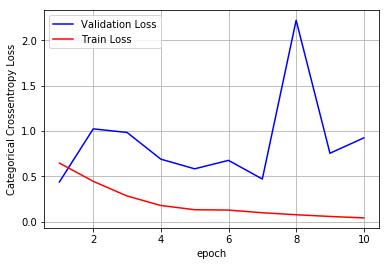

In [240]:
plot_train_cv_loss(output_2, epochs = 10)

## Conclustion

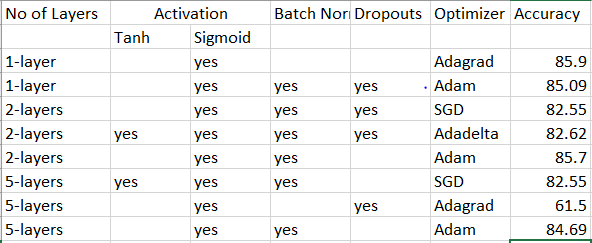

1) From the above tabel we got one layered LSTM with adam optimizer of accuracy 85.9%

2) we just took 5k reviews, if we took more data points the accuracy will be increased, due to less computational resources we limited our study to 5k data points

3) By appling the Batchnormalization and dropouts the generalization error is less